# Introduction

In this section of the IBM Data Science Professional Certificate capstone project, I'll be parsing the Wikipedia page for Falcon 9 and Falcon Heavy launches to get more data for the project.

Rather than retrieve the data from an API, as I did in the previous section, I'll use BeautifulSoup to parse the webpage:

[https://en.wikipedia.org/wiki/List_of_Falcon\_9\_and_Falcon_Heavy_launches](https://en.wikipedia.org/wiki/List_of_Falcon\_9\_and_Falcon_Heavy_launches?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)

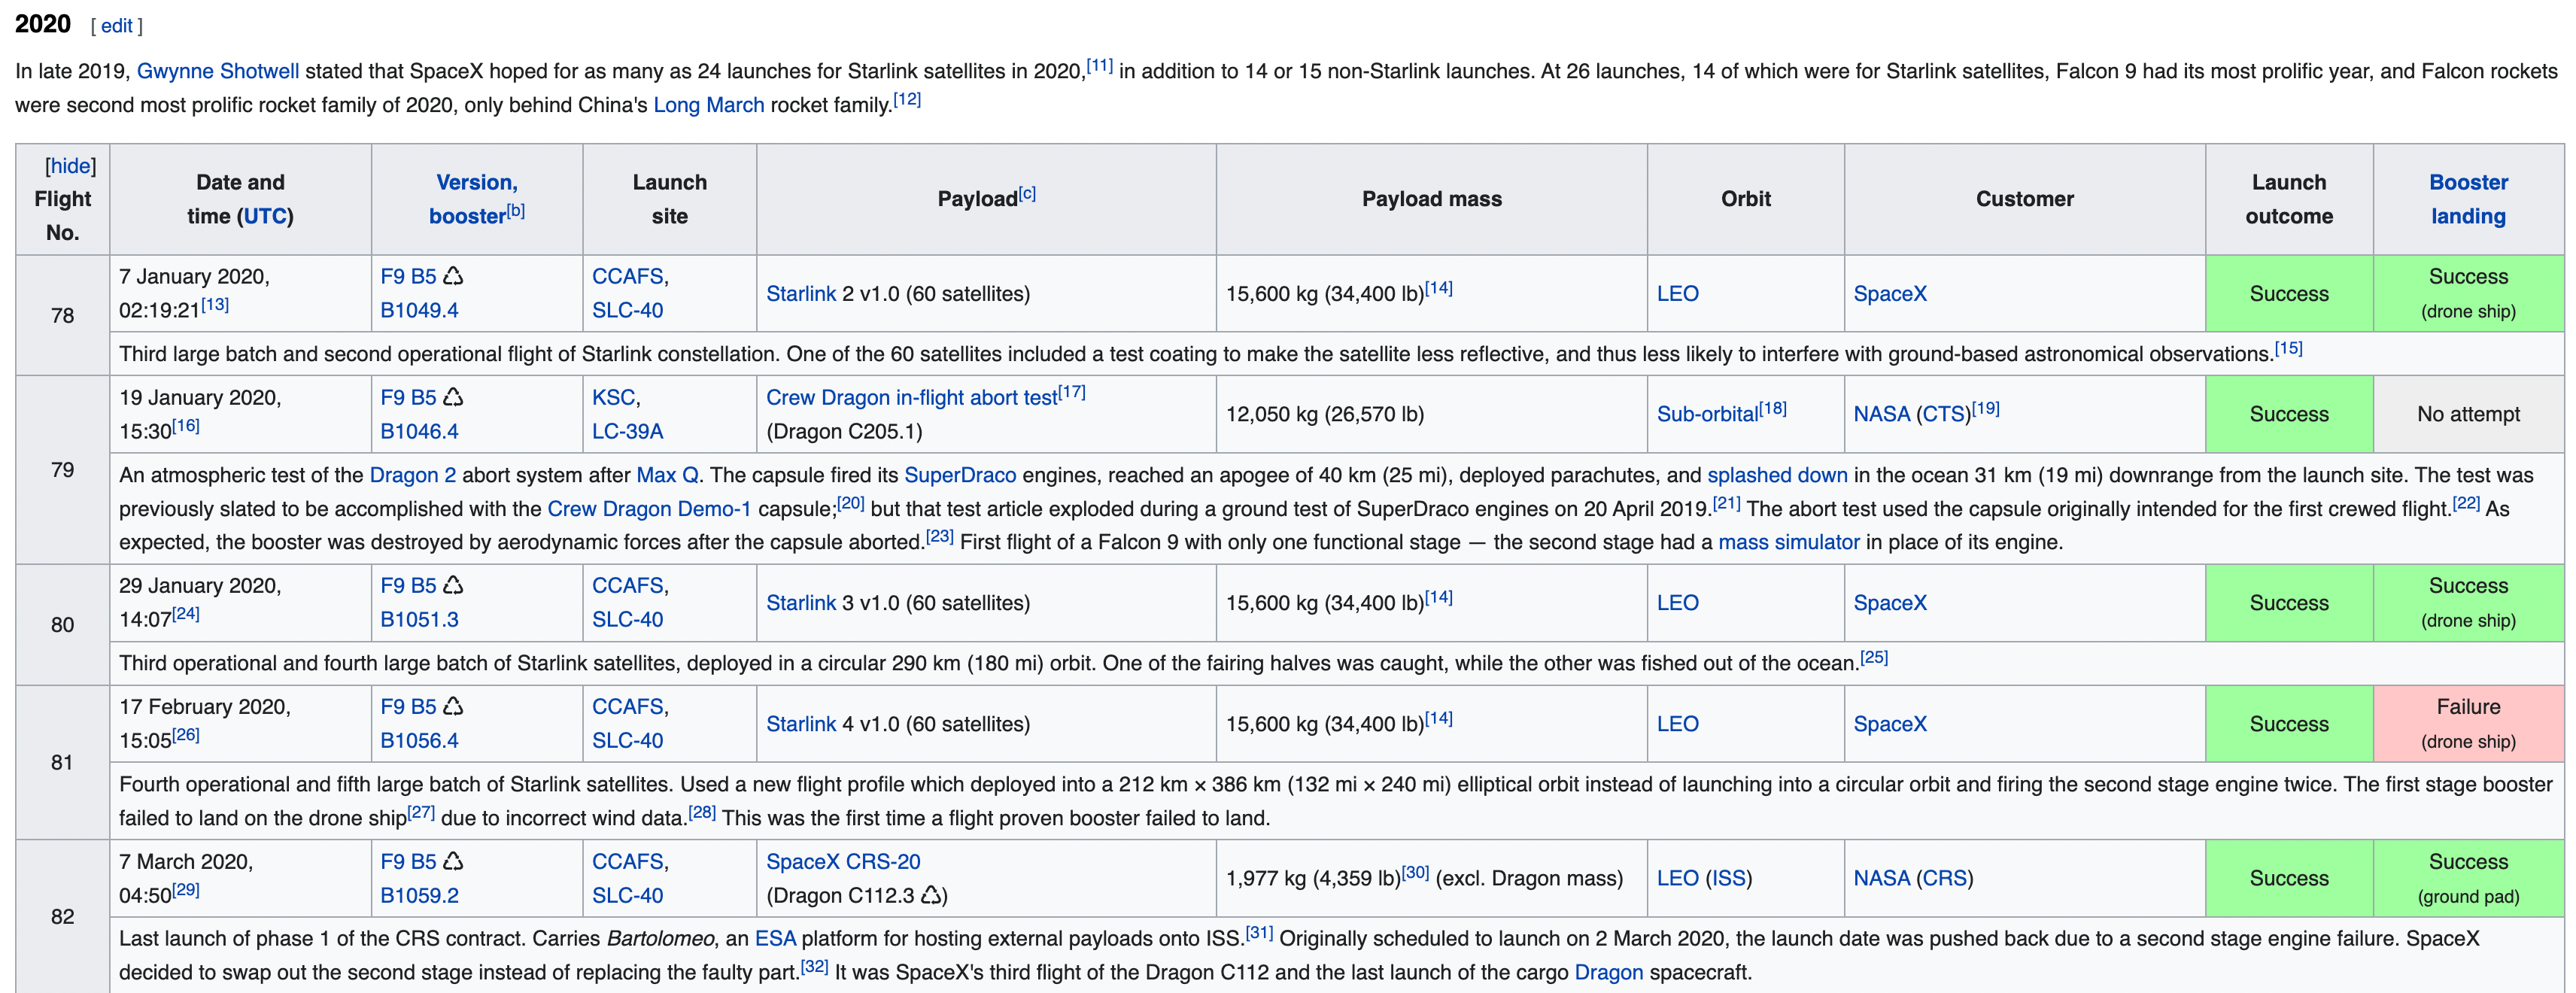

The following image shows an array of different Falcon 9 rockets:

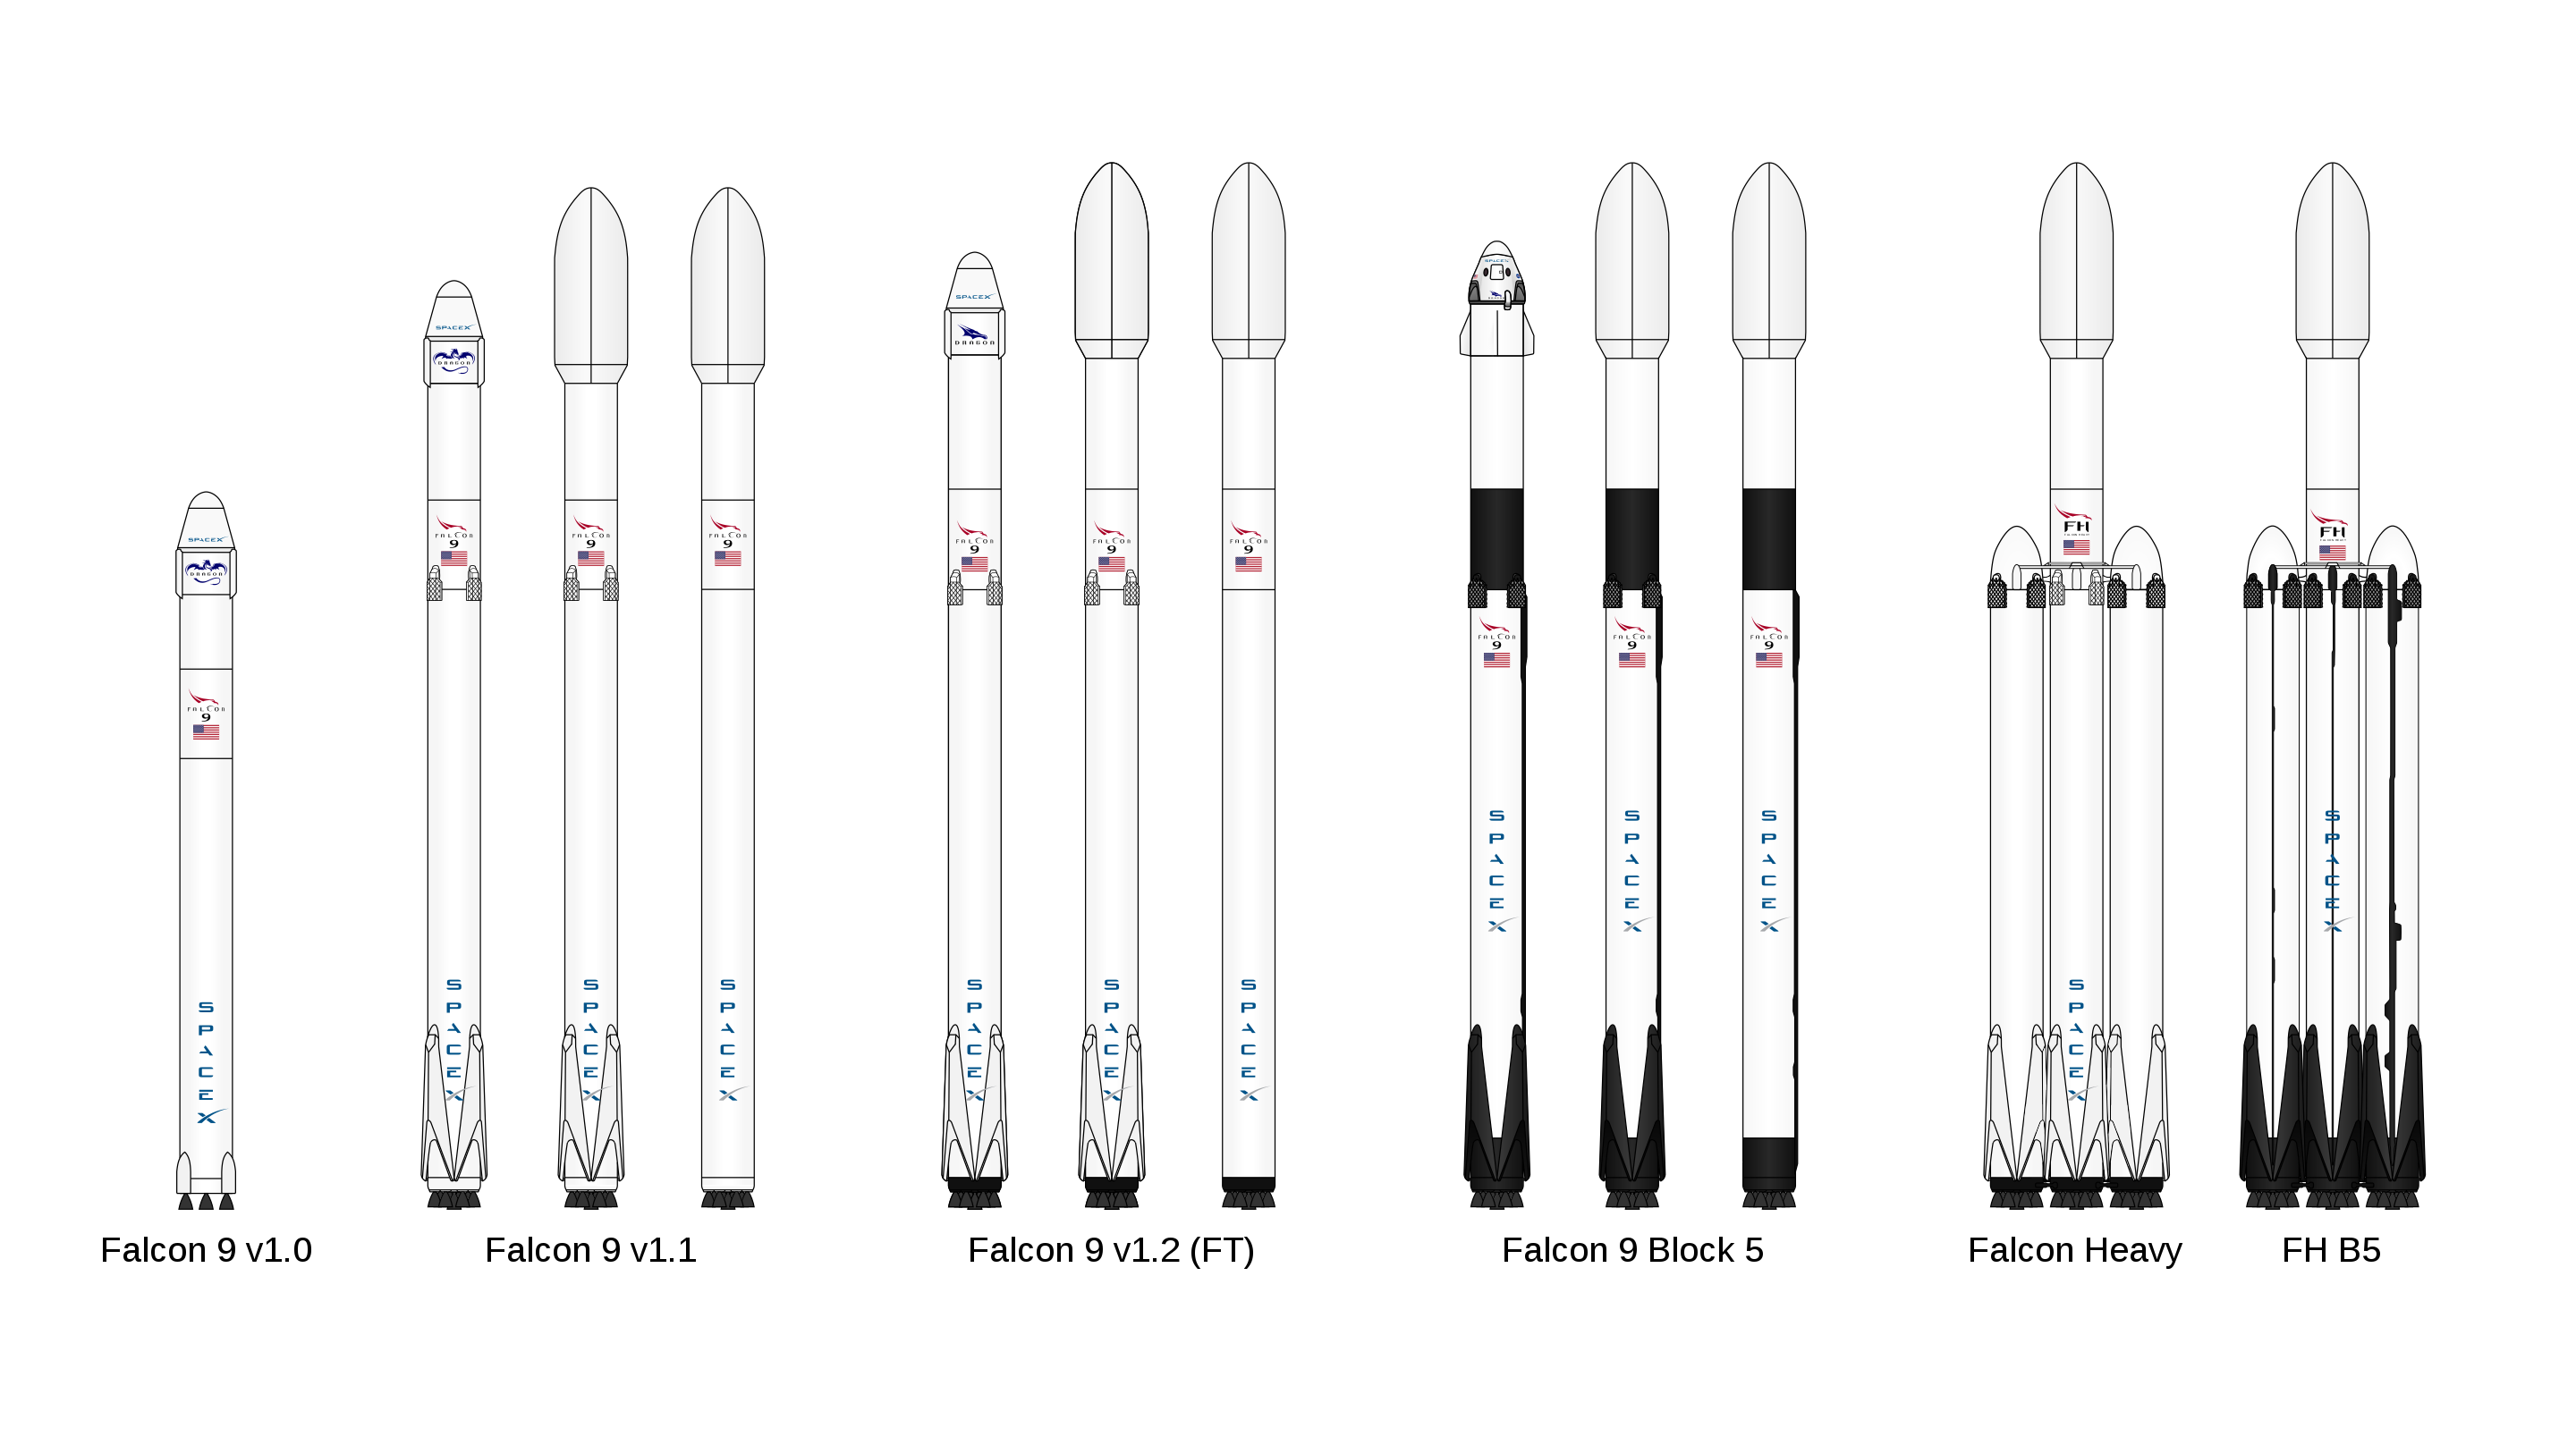

## Getting Started

Import the necessary packages:

In [1]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import copy

# static URL for consistency in data for project purposes
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

For the project, I'm using a static version of the Wikipedia page so that my data aligns with what is expected in the project guidelines. That URL is above.

Now I use the `requests` package to request the HTML page as a JSON object:

In [2]:
response = requests.get(static_url)

if response.status_code==200:
#     print(response.content)
    print('Successfully retrieved webpage.')
else:
    print('Error retrieving webpage.')

Successfully retrieved webpage.


In [3]:
soup = BeautifulSoup(response.content, 'html.parser')

# print(soup.prettify())

Getting the webpage from the internet seems to have been successful. I can see that the title of the webpage is the correct one, but let's write it out in code to be sure:

In [4]:
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

Great!

## Sifting through the HTML Data

First thing on the agenda is to get the table we want. Let's get all of the tables using BeautifulSoup's `find_all` method:

In [5]:
tables = soup.find_all('table')

# tables

First, I just need to get the table column names, so I'm going to select one table to parse first. By looking at the webpage in a browser, it's clear that the first table of interest is the third one on the page. Select it from the list:

In [6]:
falcon9_2020_table = copy.copy(tables[2])

# falcon9_2020_table

Now I will select get the column names by selecting the table headers:

In [7]:
table_headers = falcon9_2020_table.find_all(name='th')
# for tbl_header in table_headers:
#     print(tbl_header)

Clearly we need to do some processing to get the column names from each element. The project guide has the following function to extract the column names from the table headers:

In [8]:
def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()  
        # this will remove the a tags from columns 3 and 10, 
        # removing the column name in the process
        # will have to manually add the column later
    if row.sup:
        row.sup.extract()
        
    column_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(column_name.strip().isdigit()):  # if string isnt a digit
        column_name = column_name.strip()  # strip spaces 
        return column_name 

In [9]:
col_names = []

for table_header in table_headers:
    name = extract_column_from_header(table_header)
    if name is not None and len(name) > 0:
        col_names.append(name)

print(col_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


Now let's create an empty dictionary with the column names as keys:

In [10]:
launch_dict = dict.fromkeys(col_names)

# Remove irrelevant column
del launch_dict['Date and time ( )']

# initialize the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

# Added some new columns, these are the ones that 
# were not picked up earlier or were deleted
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Now we're ready to start reading in the values from the tables:

In [11]:
extracted_row = 0

# extract each table 
for table_number, table in enumerate(soup.find_all('table', 'wikitable plainrowheaders collapsible')):
    # get table row 
    for row in table.find_all("tr"):
        # check to see if first table header is a number.
        # this will correspond to a launch number
        if row.th:  # look at the FIRST table header of the row
            if row.th.string:  # look at the text of the header
                flight_number = row.th.string.strip()  # remove leading and trailing spaces
                flag = flight_number.isdigit()  # is the header a digit?
        else:
            flag=False
            
        # if it is number save the cells in our dictonary 
        if flag:
            # get table element 
            table_data = row.find_all('td')
            extracted_row += 1
            
            # flight number value
            launch_dict['Flight No.'].append(extracted_row)
            
            # get date and time, column 1
            date_time = [date_and_time.strip() for date_and_time in list(table_data[0].strings)][0:2]
            date = date_time[0].strip(',')
            time = date_time[1]
            
            launch_dict['Date'].append(date)
            launch_dict['Time'].append(time)
            
            # get booster version, column 2
            bv=''.join([booster_version for i,booster_version in enumerate(table_data[1].strings) if i%2==0])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv.strip())
            
            # get launch site, column 3
            launch_site = [x.string for x in table_data[2].find_all('a') if x.string[0] != '[']
            launch_site = ' '.join(launch_site).strip()
            launch_dict['Launch site'].append(launch_site)

            # get payload, column 4
            payload = table_data[3].a.string
            launch_dict['Payload'].append(payload)
            
            # get payload mass, column 5
            mass = unicodedata.normalize("NFKD", table_data[4].text).strip()
            new_mass = '0'
            if mass:
                new_mass = mass[0:mass.find("kg")]
                new_mass = new_mass.replace(',', '')
                new_mass = new_mass.replace('~', '')
                new_mass = new_mass.strip()
                if new_mass=='Classifie':
                    new_mass = '0'
#             print(new_mass)
            launch_dict['Payload mass'].append(new_mass)
        
            # get orbit, column 6
            orbit = table_data[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            # get customer, column 7
            customer = ''
#             print(list(table_data[6].strings))
            if table_data[6].strings:
                customer = [x.replace('\n', ' ') for x in table_data[6].strings]
                customer = [x for x in customer if x[0] != '[']
                customer = ''.join(customer).strip()
#                 print(customer)
            launch_dict['Customer'].append(customer)
            
            # get launch outcome, column 8
            launch_outcome = list(table_data[7].strings)[0].strip()
            launch_dict['Launch outcome'].append(launch_outcome)
            
            # get booster landing, column 9
            booster_landing = list(table_data[8].strings)[0].strip()
            launch_dict['Booster landing'].append(booster_landing)

And now create a dataframe with the dictionary:

In [12]:
df = pd.DataFrame(launch_dict)

# fix one mass range
df.loc[df['Payload mass'].isin(['5000–6000']), 'Payload mass'] = '5500'

df.head(10)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS SLC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS SLC-40,Dragon,0,LEO,NASA (COTS) NRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS SLC-40,Dragon,525,LEO,NASA (COTS),Success,F9 v1.0B0005.1,No attempt,22 May 2012,07:44
3,4,CCAFS SLC-40,SpaceX CRS-1,4700,LEO,NASA (CRS),Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS SLC-40,SpaceX CRS-2,4877,LEO,NASA (CRS),Success,F9 v1.0B0007.1,No attempt,1 March 2013,15:10
5,6,VAFB SLC-4E,CASSIOPE,500,Polar orbit,MDA,Success,F9 v1.1B1003,Uncontrolled,29 September 2013,16:00
6,7,CCAFS SLC-40,SES-8,3170,GTO,SES,Success,F9 v1.1,No attempt,3 December 2013,22:41
7,8,CCAFS SLC-40,Thaicom 6,3325,GTO,Thaicom,Success,F9 v1.1,No attempt,6 January 2014,22:06
8,9,Cape Canaveral LC-40,SpaceX CRS-3,2296,LEO,NASA (CRS),Success,F9 v1.1,Controlled,18 April 2014,19:25
9,10,Cape Canaveral LC-40,Orbcomm-OG2,1316,LEO,Orbcomm,Success,F9 v1.1,Controlled,14 July 2014,15:15


In [13]:
df['Launch site'].value_counts()

CCAFS SLC-40             40
KSC LC-39A               33
Cape Canaveral LC-40     19
VAFB SLC-4E              16
CCSFS SLC-40             12
Cape Canaveral SLC-40     1
Name: Launch site, dtype: int64

As shown above, there are four different launch site categories that correspond to Cape Canaveral. CCAFS refers to Cape Canaveral Air Force Station, but was changed to CCSFS (Cape Canaveral Space Force Station) in 2020.

While I would like to combine all four of these launch site names into a single one, I wonder if there is a correlation between the success of the booster landing and the name of the launch site, i.e. an older launch site name may indicate a higher likelihood for the booster landing to fail because the program was in its infancy at the time. I'll verify this:

In [14]:
df[['Launch site', 'Booster landing']].value_counts()

Launch site            Booster landing
KSC LC-39A             Success            28
CCAFS SLC-40           Success            24
                       No attempt         11
CCSFS SLC-40           Success            11
VAFB SLC-4E            Success            10
Cape Canaveral LC-40   Success             6
KSC LC-39A             No attempt          4
Cape Canaveral LC-40   Failure             4
                       No attempt          4
CCAFS SLC-40           Failure             4
Cape Canaveral LC-40   Controlled          3
VAFB SLC-4E            No attempt          3
                       Failure             1
                       Controlled          1
CCAFS SLC-40           Controlled          1
KSC LC-39A             Failure             1
Cape Canaveral SLC-40  Success             1
Cape Canaveral LC-40   Uncontrolled        1
                       Precluded           1
CCSFS SLC-40           Failure             1
VAFB SLC-4E            Uncontrolled        1
dtype: int64

It doesn't look like the newer launch site name indicates more successful booster landings, so I'll go ahead and combine them all into one location name.

In [15]:
cc_names = ['CCAFS SLC-40', 'Cape Canaveral LC-40', 'CCSFS SLC-40', 'Cape Canaveral SLC-40']
df.loc[df['Launch site'].isin(cc_names), 'Launch site'] = 'CCSFS SLC-40'

In [16]:
df['Launch site'].value_counts()

CCSFS SLC-40    72
KSC LC-39A      33
VAFB SLC-4E     16
Name: Launch site, dtype: int64

In [17]:
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCSFS SLC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCSFS SLC-40,Dragon,0,LEO,NASA (COTS) NRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCSFS SLC-40,Dragon,525,LEO,NASA (COTS),Success,F9 v1.0B0005.1,No attempt,22 May 2012,07:44
3,4,CCSFS SLC-40,SpaceX CRS-1,4700,LEO,NASA (CRS),Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCSFS SLC-40,SpaceX CRS-2,4877,LEO,NASA (CRS),Success,F9 v1.0B0007.1,No attempt,1 March 2013,15:10


Great! Seems to have worked swimmingly. Now we can finally export the CSV file.

In [18]:
df.to_csv('datasets/launch_data_falcon9_wiki.csv', index=False)